# Prompt

You are given two images hw4-input.jpg and hw4-output.jpg. Both are historic aerial images of UNT campus copied from the UNT Digital Library. If you look at hw4-input.jpg, it is darker overall and can be made brighter. I want it to have the same brightness distribution as hw4-output.jpg. Your task is to use the histogram matching/specification technique described in pages 156-163. You would obtain 𝑝𝑟(𝑟𝑗) from hw4-input.jpg and 𝑝𝑧(𝑧𝑖) from hw4-output.jpg and perform the 4 steps described on page 158. Submit a Jupyter notebook (ipynb) file. Make sure you run your code and leave all the input and output in the ipynb file. You need to show histogram of 𝑝𝑟(𝑟𝑗), histogram of 𝑝𝑧(𝑧𝑖), histogram of the output image, the output image and an image similar to Figure 3.21 that shows the mapping from input brightness levels to output brightness levels.

# Code

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from google.colab.patches import cv2_imshow

## Global Variables

In [ ]:
L = 256

## Get Images

In [10]:
# Directory
img_dir = "/content/drive/MyDrive/Classes/CSCE 5225 Image Processing"
img_inp = img_dir + "hw4-input.jpg"
img_out = img_dir + "hw4-output.jpg"

# Load
# img_inp = cv2.imread(img_inp)
# img_out = cv2.imread(img_out)

# Convert to grayscale
# img_inp = cv2.cvtColor(img_inp, cv2.COLOR_BGR2GRAY)
# img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2GRAY)

In [11]:
img_inp = plt.imread(img_inp)

FileNotFoundError: ignored

In [6]:
cv2_imshow(img_inp)

AttributeError: ignored

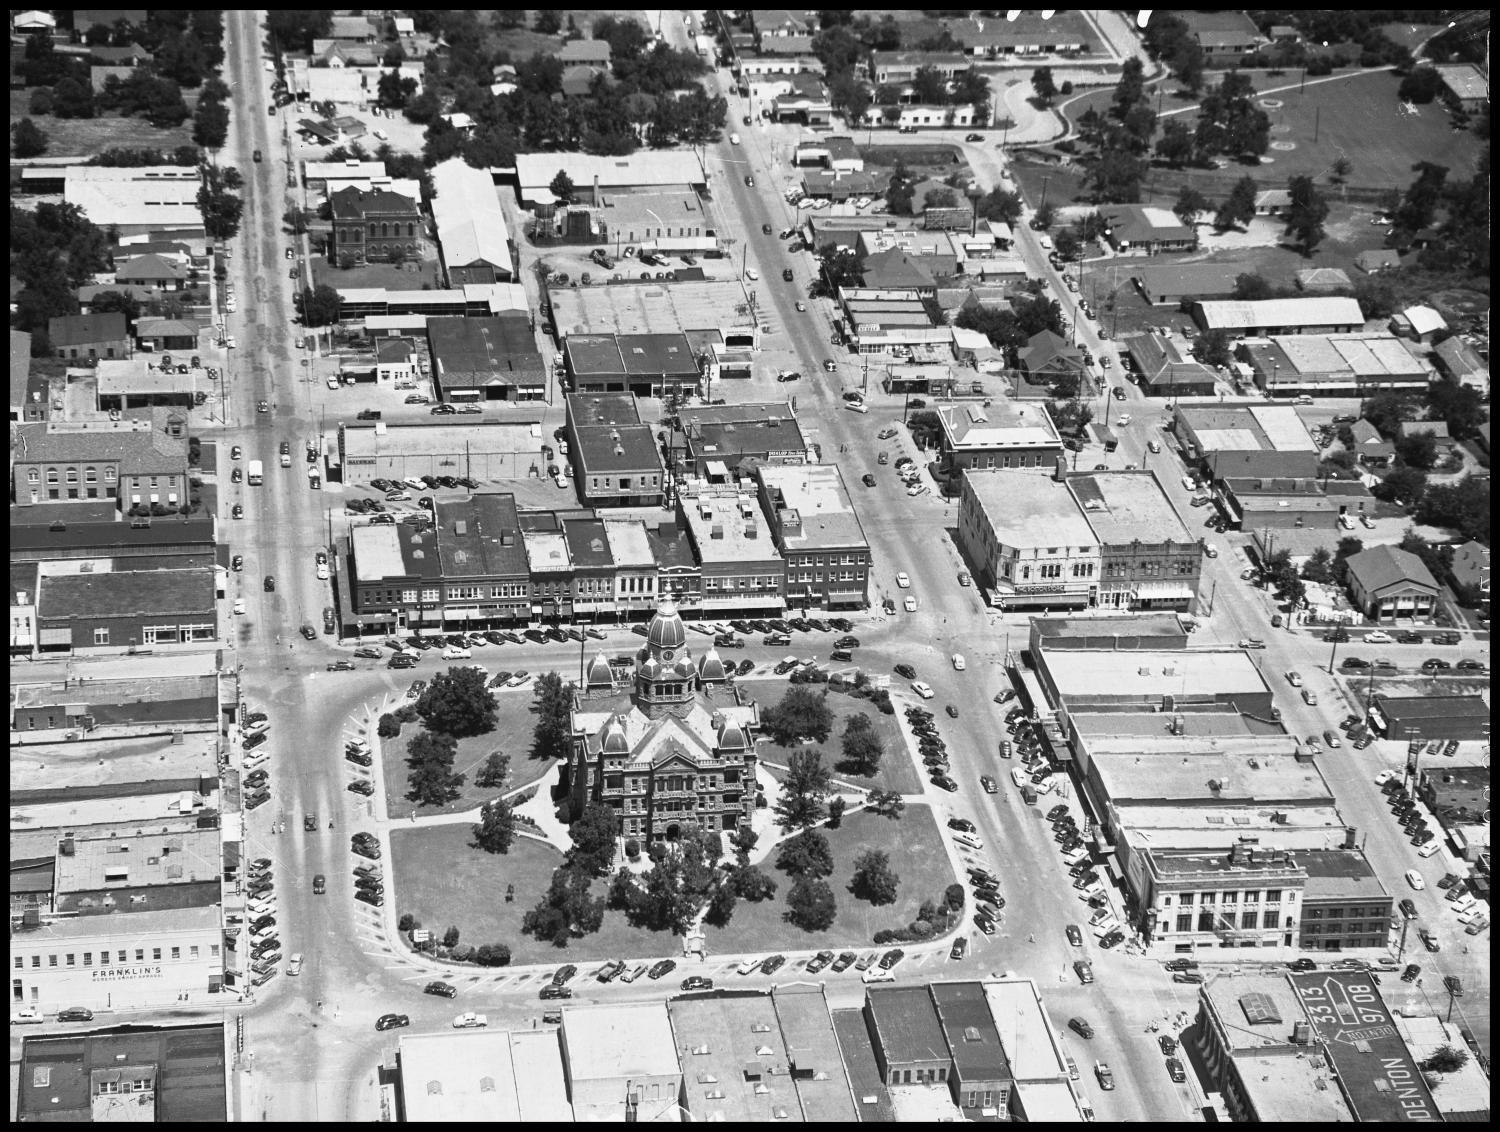

In [ ]:
cv2_imshow(img_out)

In [ ]:
# Trim images
img_inp = img_inp[99:1115, 115:1388]
img_out = img_out[10:1122, 10:1490]

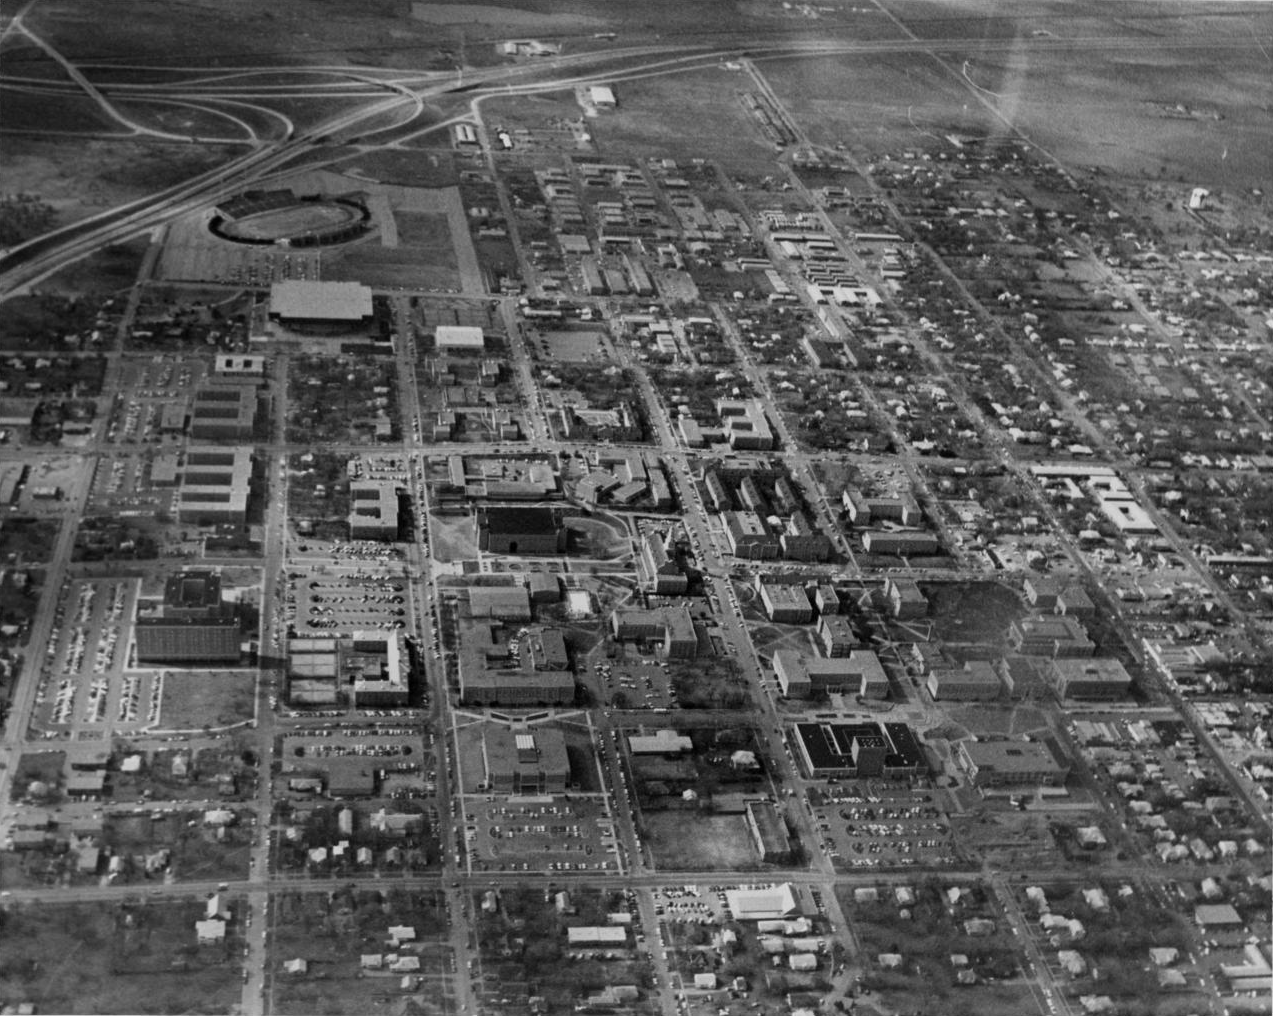

In [ ]:
cv2_imshow(img_inp)

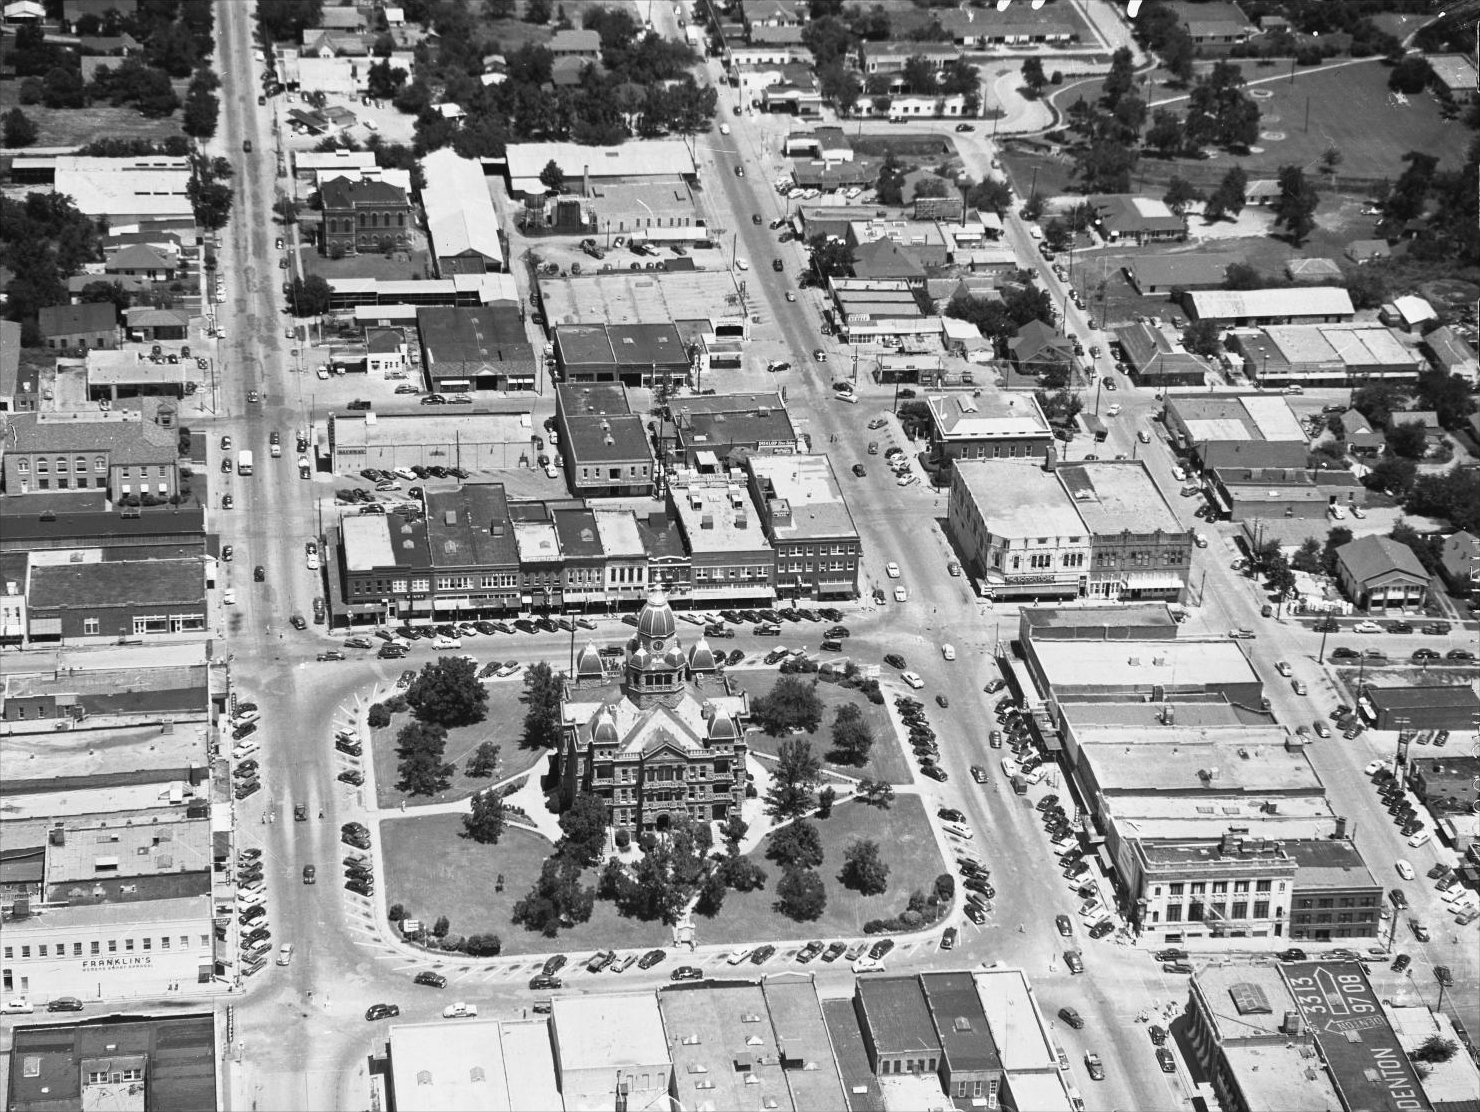

In [ ]:
cv2_imshow(img_out)

## Get Image Histograms

In [ ]:
# Function to display histograms side-by-side
def plot_histograms(inp_bins, out_bins, title=None, share_y=True):
    fig, ax = plt.subplots(1, 2, sharey=share_y, figsize=(15, 5))

    # Input image
    ax[0].bar(list(inp_bins.keys()), list(inp_bins.values()))
    ax[0].set_title("Input Image Histogram")

    # Output image
    ax[1].bar(list(out_bins.keys()), list(out_bins.values()))
    ax[1].set_title("Output Image Histogram")

    # Title
    if title is not None:
        fig.suptitle(title)

    plt.show()

In [ ]:
# Function to get histogram values
def get_img_histogram(img):
    unique, counts = np.unique(img, return_counts=True)
    zipped = dict(zip(unique, counts))

    bins = {}
    for i in range(L):
        if i in zipped:
            bins.update({i: int(zipped[i])})
        else:
            bins.update({i: 0})
    
    return bins

In [ ]:
# Get histogram values
img_inp_bins = get_img_histogram(img_inp)
img_out_bins = get_img_histogram(img_out)

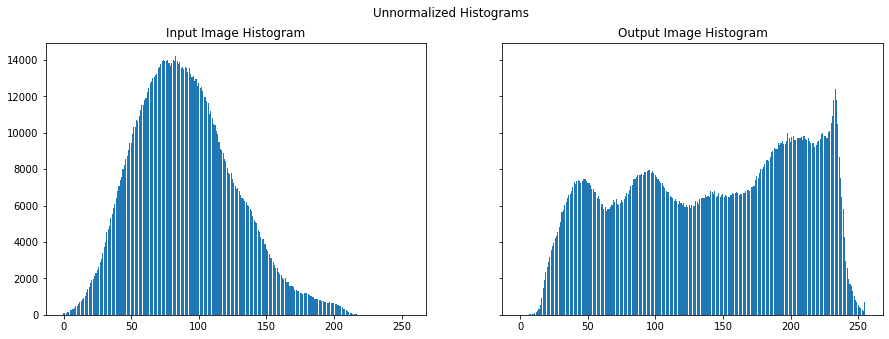

In [ ]:
# Display histograms
plot_histograms(img_inp_bins, img_out_bins, title="Unnormalized Histograms")

In [ ]:
# Function to get normalzied histogram values
def get_img_histogram_normalized(img):

    # Get values
    m, n = img.shape
    bins = get_img_histogram(img)

    # Normalize
    for i in bins:
        bins[i] = bins[i] / (m * n)

    return bins

In [ ]:
# Get histogram values
img_inp_bins_norm  = get_img_histogram_normalized(img_inp)
img_out_bins_norm = get_img_histogram_normalized(img_out)

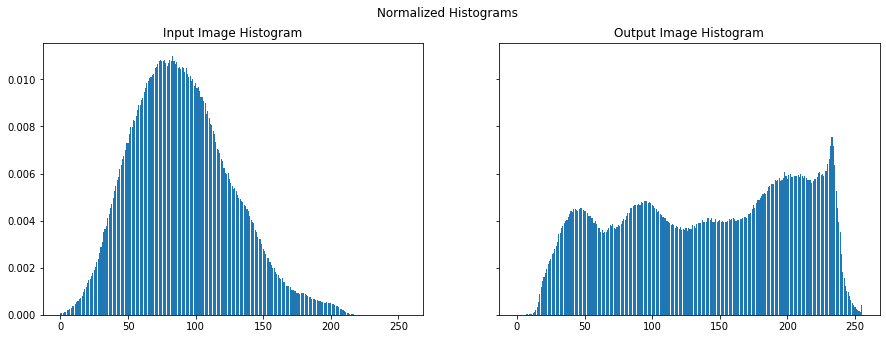

In [ ]:
# Display histograms
plot_histograms(img_inp_bins_norm, img_out_bins_norm, title="Normalized Histograms")

## Get Mappings

In [ ]:
# Get integral values at locations (s_k and z_k)
def get_integral(bins_norm, k):
    s_k = 0
    for i in range(k + 1):
        s_k += bins_norm[i]
    s_k *= L - 1
    return s_k

In [ ]:
# Get maping of bin values to rounded integral values
def get_integral_map(bins_norm, k):

    # Build dict
    old_to_new = {}
    for i in range(k + 1):
        old_to_new.update({i: 0})

    # Get integral values
    for i in range(k + 1):
        s_k = get_integral(bins_norm, i)
        r_s_k = round(s_k)
        old_to_new[i] = r_s_k

    return old_to_new

In [ ]:
# Find closest value in a list
def closest(l, val): 
    return l[min(range(len(l)), key = lambda i: abs(l[i] - val))]

In [ ]:
# Map old values in input image to new values based on target (output) image
def build_map(old_to_new_inp, old_to_new_out):

    # Bulid out list for closest-value matching
    out = []
    out_vals = list(old_to_new_out.values())
    for i in old_to_new_out:
        out.append([i, old_to_new_out[i]])

    # Initial mapping build
    mapping = {}
    for s_k in list(set(old_to_new_inp.values())):
        mapping.update({s_k: None})
        
        # Get exact matches of s_k to G(z_q)
        for k in old_to_new_out:
            if old_to_new_out[k] == s_k:
                mapping[s_k] = k
                break

    # If mapping is missing, get closest value mapping
    for s_k in mapping:
        if mapping[s_k] is None:
            c = closest(out_vals, s_k)
            i = out_vals.index(c)
            mapping[s_k] = out[i][0]

    # Map directly from input bin to output bin
    mapping_new = {}
    for i in range(L):
        x = old_to_new_inp[i]
        if x in mapping:
            mapping_new.update({i: mapping[x]})
            
    return mapping_new

In [ ]:
# Get mappings of images
old_to_new_inp = get_integral_map(img_inp_bins_norm, L - 1)
old_to_new_out = get_integral_map(img_out_bins_norm, L - 1)

In [ ]:
# Get final map
mapping = build_map(old_to_new_inp, old_to_new_out)

## Plot Transformation Function

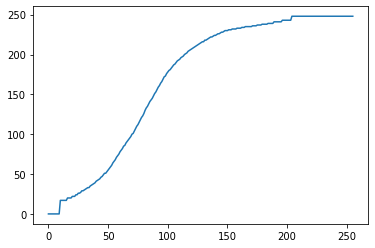

In [ ]:
# Get values
mapping_disp_x = []
mapping_disp_y = []
for k in range(L):
    mapping_disp_x.append(k)
    if k in mapping:
        mapping_disp_y.append(mapping[k])
    else:
        mapping_disp_y.append(k)

# Plot
plt.plot(mapping_disp_x, mapping_disp_y)
plt.show()

## Adjust Input Image

In [ ]:
# Map values
# inp_m, inp_n = img_inp.shape
img_adj = np.zeros(img_inp.shape)
for i in range(img_inp.shape[0]):
    for j in range(img_inp.shape[1]):
        x = img_inp[i, j]
        if x in mapping:
            x = mapping[x]
        img_adj[i, j] = x

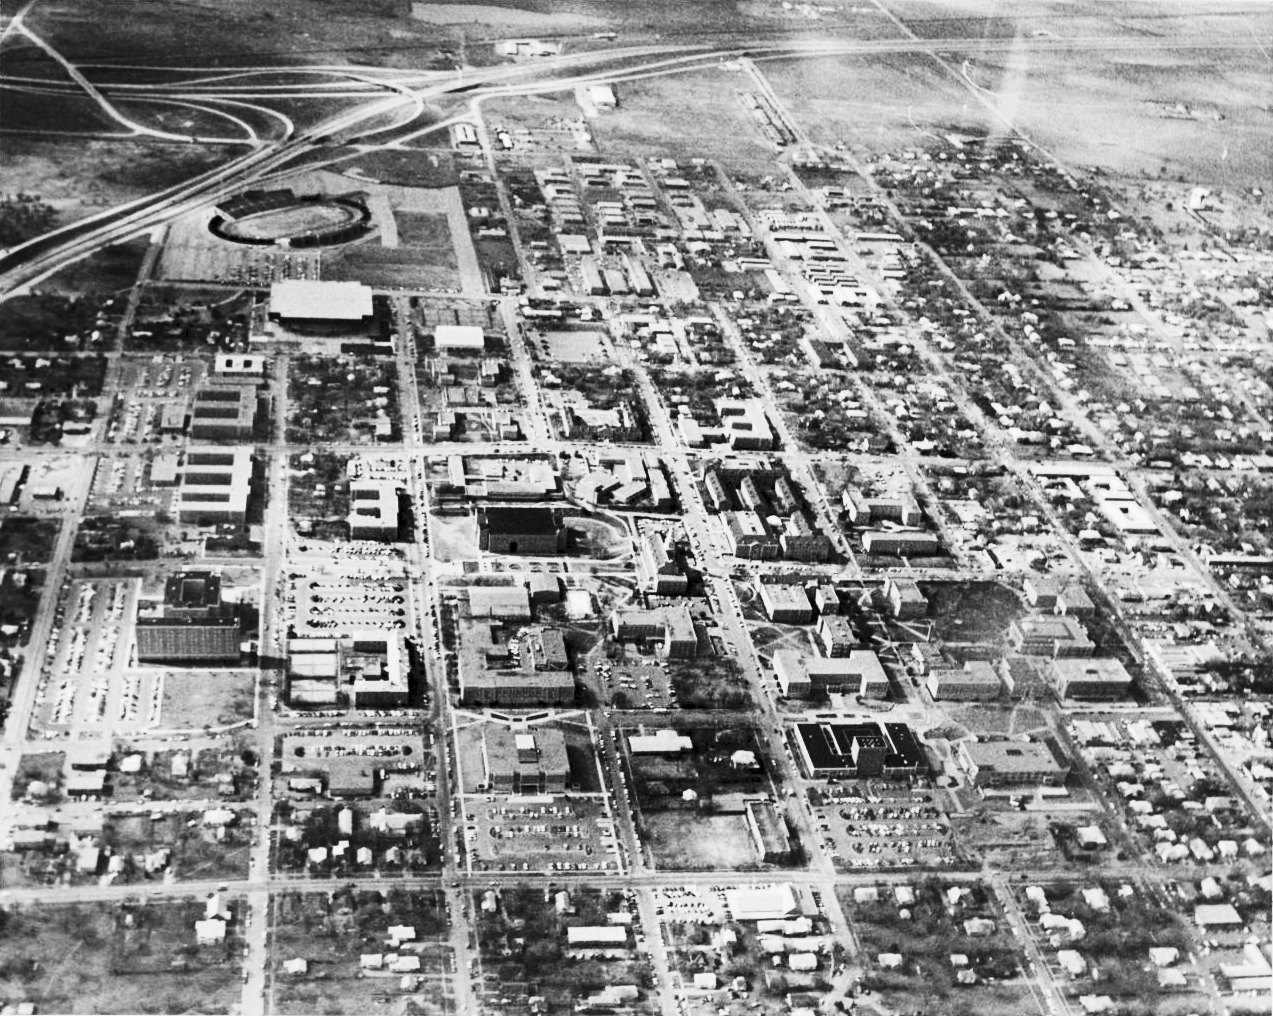

In [ ]:
# Display
cv2_imshow(img_adj)

## Display All Histograms

In [ ]:
# Histograms of adjusted image
img_adj_bins = get_img_histogram(img_adj)
img_adj_bins_norm = get_img_histogram_normalized(img_adj)

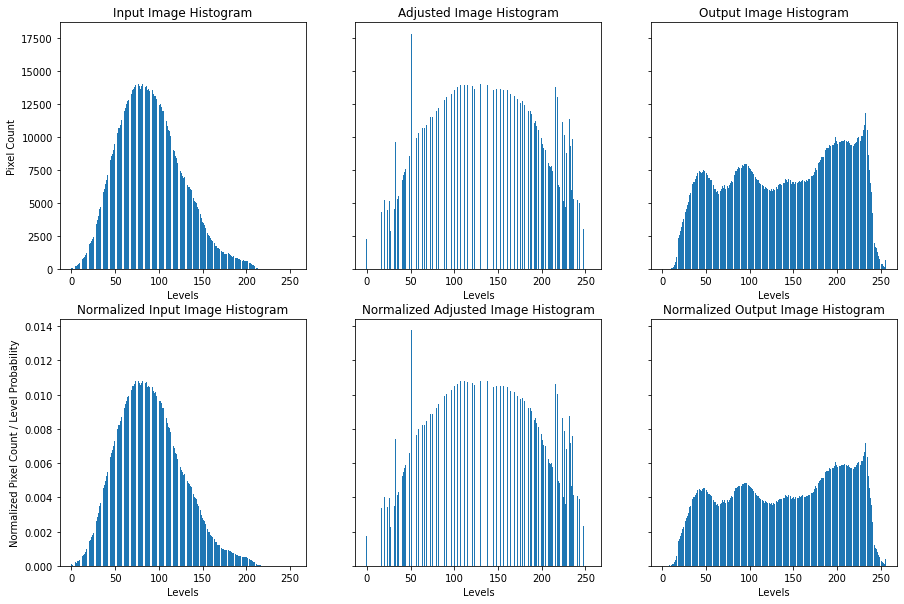

In [ ]:
# Plot histograms
fig, ax = plt.subplots(2, 3, sharey="row", figsize=(15, 10))

# Plot unnormalized histograms
ax[0, 0].bar(list(img_inp_bins.keys()), list(img_inp_bins.values()))
ax[0, 0].set_title("Input Image Histogram")

ax[0, 1].bar(list(img_adj_bins.keys()), list(img_adj_bins.values()))
ax[0, 1].set_title("Adjusted Image Histogram")

ax[0, 2].bar(list(img_out_bins.keys()), list(img_out_bins.values()))
ax[0, 2].set_title("Output Image Histogram")

# Plot normalized histograms
ax[1, 0].bar(list(img_inp_bins_norm.keys()), list(img_inp_bins_norm.values()))
ax[1, 0].set_title("Normalized Input Image Histogram")

ax[1, 1].bar(list(img_adj_bins_norm.keys()), list(img_adj_bins_norm.values()))
ax[1, 1].set_title("Normalized Adjusted Image Histogram")

ax[1, 2].bar(list(img_out_bins_norm.keys()), list(img_out_bins_norm.values()))
ax[1, 2].set_title("Normalized Output Image Histogram")

# Set axis labels
for a in ax.flat:
    a.set(xlabel="Levels")
labels = ["Pixel Count", "Normalized Pixel Count / Level Probability"]
for a, row in zip(ax[:, 0], labels):
    a.set_ylabel(row)

plt.show()